In [1]:
from __future__ import division
from __future__ import print_function

## Some Code

* First let's add a function to uniquely label repeated k-mers

In [3]:
def kmersUnique(seq, k):
    """ extracts all *k*-mers from *seq* string, while appending a
        unique subscript to each repeated k-mer """
    kmers = sorted([seq[i:i+k] for i in range(len(seq)-k+1)])  # trick is to sort them first making repeats adjacent
    for i in range(1,len(kmers)):
        if (kmers[i] == kmers[i-1][0:k]):           # check adjacent k-mers
            t = kmers[i-1].find('_')
            if (t >= 0):                            # more than 2 repeats
                n = int(kmers[i-1][t+1:]) + 1
                kmers[i] = kmers[i] + "_" + str(n)
            else:                                   # first repeat
                kmers[i-1] = kmers[i-1] + "_1"
                kmers[i] = kmers[i] + "_2"
    return kmers

kmers = kmersUnique("GACGGCGGCGCACGGCGCAA", 5)
print(kmers)

['ACGGC_1', 'ACGGC_2', 'CACGG', 'CGCAA', 'CGCAC', 'CGGCG_1', 'CGGCG_2', 'CGGCG_3', 'GACGG', 'GCACG', 'GCGCA_1', 'GCGCA_2', 'GCGGC', 'GGCGC_1', 'GGCGC_2', 'GGCGG']


## Our Graph Class from last lecture

In [2]:
import itertools

class Graph:
    def __init__(self, vlist=[]):
        """ Initialize a Graph with an optional vertex list """
        self.index = {v:i for i,v in enumerate(vlist)}
        self.vertex = {i:v for i,v in enumerate(vlist)}
        self.edge = []
        self.edgelabel = []
        
    def addVertex(self, label):
        """ Add a labeled vertex to the graph """
        index = len(self.index)
        self.index[label] = index
        self.vertex[index] = label
        
    def addEdge(self, vsrc, vdst, label='', repeats=True):
        """ Add a directed edge to the graph, with an optional label. 
        Repeated edges are distinct, unless repeats is set to False. """
        e = (self.index[vsrc], self.index[vdst])
        if (repeats) or (e not in self.edge):
            self.edge.append(e)
            self.edgelabel.append(label)
            
    def hamiltonianPath(self):
        """ A Brute-force method for finding a Hamiltonian Path. 
        Basically, all possible N! paths are enumerated and checked
        for edges. Since edges can be reused there are no distictions
        made for *which* version of a repeated edge. """
        for path in itertools.permutations(sorted(self.index.values())):
            for i in xrange(len(path)-1):
                if ((path[i],path[i+1]) not in self.edge):
                    break
            else:
                return [self.vertex[i] for i in path]
        return []
    
    def SearchTree(self, path, verticesLeft):
        """ A recursive Branch-and-Bound Hamiltonian Path search. 
        Paths are extended one node at a time using only available
        edges from the graph. """
        if (len(verticesLeft) == 0):
            self.PathV2result = [self.vertex[i] for i in path]
            return True
        for v in verticesLeft:
            if (len(path) == 0) or ((path[-1],v) in self.edge):
                if self.SearchTree(path+[v], [r for r in verticesLeft if r != v]):
                    return True
        return False
    
    def hamiltonianPathV2(self):
        """ A wrapper function for invoking the Branch-and-Bound 
        Hamiltonian Path search. """
        self.PathV2result = []
        self.SearchTree([],sorted(self.index.values()))                
        return self.PathV2result
    
    def degrees(self):
        """ Returns two dictionaries with the inDegree and outDegree
        of each node from the graph. """
        inDegree = {}
        outDegree = {}
        for src, dst in self.edge:
            outDegree[src] = outDegree.get(src, 0) + 1
            inDegree[dst] = inDegree.get(dst, 0) + 1
        return inDegree, outDegree
    
    def verifyAndGetStart(self):
        inDegree, outDegree = self.degrees()
        start = 0
        end = 0
        for vert in self.vertex:
            ins = inDegree.get(vert,0)
            outs = outDegree.get(vert,0)
            if (ins == outs):
                continue
            elif (ins - outs == 1):
                end = vert
            elif (outs - ins == 1):
                start = vert
            else:
                start, end = -1, -1
                break
        if (start >= 0) and (end >= 0):
            return start
        else:
            return -1

    def eulerianPath(self):
        graph = [(src,dst) for src,dst in self.edge]
        currentVertex = self.verifyAndGetStart()
        path = [currentVertex]
        # "next" is where vertices get inserted into our tour
        # it starts at the end (i.e. it is the same as appending),
        # but later "side-trips" will insert in the middle
        next = 1
        while len(graph) > 0:
            for edge in graph:
                if (edge[0] == currentVertex):
                    currentVertex = edge[1]
                    graph.remove(edge)
                    path.insert(next, currentVertex)
                    next += 1
                    break
            else:
                for edge in graph:
                    try:
                        next = path.index(edge[0]) + 1
                        currentVertex = edge[0]
                        break
                    except ValueError:
                        continue
                else:
                    print("There is no path!")
                    return False
        return path
    
    def eulerEdges(self, path):
        edgeId = {}
        for i in range(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeList = []
        for i in range(len(path)-1):
            edgeList.append(self.edgelabel[edgeId[path[i],path[i+1]].pop()])            
        return edgeList
    
    def render(self, highlightPath=[]):
        """ Outputs a version of the graph that can be rendered
        using graphviz tools (http://www.graphviz.org/)."""
        edgeId = {}
        for i in xrange(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeSet = set()
        for i in xrange(len(highlightPath)-1):
            src = self.index[highlightPath[i]]
            dst = self.index[highlightPath[i+1]]
            edgeSet.add(edgeId[src,dst].pop())
        result = ''
        result += 'digraph {\n'
        result += '   graph [nodesep=2, size="10,10"];\n'
        for index, label in self.vertex.iteritems():
            result += '    N%d [shape="box", style="rounded", label="%s"];\n' % (index, label)
        for i, e in enumerate(self.edge):
            src, dst = e
            result += '    N%d -> N%d' % (src, dst)
            label = self.edgelabel[i]
            if (len(label) > 0):
                if (i in edgeSet):
                    result += ' [label="%s", penwidth=3.0]' % (label)
                else:
                    result += ' [label="%s"]' % (label)
            elif (i in edgeSet):
                result += ' [penwidth=3.0]'                
            result += ';\n'                
        result += '    overlap=false;\n'
        result += '}\n'
        return result

## Finding Paths in our K-mer De Bruijn Graphs

In [4]:
k = 5
target = "GACGGCGGCGCACGGCGCAA"
kmers = kmersUnique(target, k)
G1 = Graph(kmers)
for vsrc in kmers:
    for vdst in kmers:
        if (vsrc[1:k] == vdst[0:k-1]):
            G1.addEdge(vsrc,vdst)
path = G1.hamiltonianPathV2()

print(path)
seq = path[0][0:k]
for kmer in path[1:]:
    seq += kmer[k-1]
print(seq)
print(seq == target)

['GACGG', 'ACGGC_1', 'CGGCG_1', 'GGCGC_1', 'GCGCA_1', 'CGCAC', 'GCACG', 'CACGG', 'ACGGC_2', 'CGGCG_2', 'GGCGG', 'GCGGC', 'CGGCG_3', 'GGCGC_2', 'GCGCA_2', 'CGCAA']
GACGGCGCACGGCGGCGCAA
False


## How about an Euler Path?

In [14]:
k = 5
target = "GACGGCGGCGCACGGCGCAA"
kmers = kmersUnique(target, k)
print(kmers)

nodes = sorted(set([code[:k-1] for code in kmers] + [code[1:k] for code in kmers]))
print(nodes)
G2 = Graph(nodes)
for code in kmers:
   G2.addEdge(code[:k-1],code[1:k],code)
path = G2.eulerianPath()
print(path)
path = G2.eulerEdges(path)
print(path)

seq = path[0][0:k]
for kmer in path[1:]:
    seq += kmer[k-1]
print(seq)
print(seq == target)

['ACGGC_1', 'ACGGC_2', 'CACGG', 'CGCAA', 'CGCAC', 'CGGCG_1', 'CGGCG_2', 'CGGCG_3', 'GACGG', 'GCACG', 'GCGCA_1', 'GCGCA_2', 'GCGGC', 'GGCGC_1', 'GGCGC_2', 'GGCGG']
['ACGG', 'CACG', 'CGCA', 'CGGC', 'GACG', 'GCAA', 'GCAC', 'GCGC', 'GCGG', 'GGCG']
[4, 0, 3, 9, 8, 3, 9, 7, 2, 6, 1, 0, 3, 9, 7, 2, 5]
['GACGG', 'ACGGC_2', 'CGGCG_3', 'GGCGG', 'GCGGC', 'CGGCG_2', 'GGCGC_2', 'GCGCA_2', 'CGCAC', 'GCACG', 'CACGG', 'ACGGC_1', 'CGGCG_1', 'GGCGC_1', 'GCGCA_1', 'CGCAA']
GACGGCGGCGCACGGCGCAA
True


## Choose a bigger k-mer

In [15]:
k = 8
target = "GACGGCGGCGCACGGCGCAA"
kmers = kmersUnique(target, k)
print(kmers)
nodes = sorted(set([code[:k-1] for code in kmers] + [code[1:k] for code in kmers]))
print(nodes)
G3 = Graph(nodes)
for code in kmers:
   G3.addEdge(code[:k-1],code[1:k],code)
path = G3.eulerianPath()
print(path)
path = G3.eulerEdges(path)
print(path)

seq = path[0][0:k]
for kmer in path[1:]:
    seq += kmer[k-1]
print(seq)
print(seq == target)

['ACGGCGCA', 'ACGGCGGC', 'CACGGCGC', 'CGCACGGC', 'CGGCGCAA', 'CGGCGCAC', 'CGGCGGCG', 'GACGGCGG', 'GCACGGCG', 'GCGCACGG', 'GCGGCGCA', 'GGCGCACG', 'GGCGGCGC']
['ACGGCGC', 'ACGGCGG', 'CACGGCG', 'CGCACGG', 'CGGCGCA', 'CGGCGGC', 'GACGGCG', 'GCACGGC', 'GCGCACG', 'GCGGCGC', 'GGCGCAA', 'GGCGCAC', 'GGCGGCG']
[6, 1, 5, 12, 9, 4, 11, 8, 3, 7, 2, 0, 4, 10]
['GACGGCGG', 'ACGGCGGC', 'CGGCGGCG', 'GGCGGCGC', 'GCGGCGCA', 'CGGCGCAC', 'GGCGCACG', 'GCGCACGG', 'CGCACGGC', 'GCACGGCG', 'CACGGCGC', 'ACGGCGCA', 'CGGCGCAA']
GACGGCGGCGCACGGCGCAA
True


## Applied to the Hamiltonian Solution

In [16]:
k = 8
target = "GACGGCGGCGCACGGCGCAA"
kmers = kmersUnique(target, k)
G4 = Graph(kmers)
for vsrc in kmers:
    for vdst in kmers:
        if (vsrc[1:k] == vdst[0:k-1]):
            G4.addEdge(vsrc,vdst)
path = G4.hamiltonianPathV2()

print(path)
seq = path[0][0:k]
for kmer in path[1:]:
    seq += kmer[k-1]
print(seq)
print(seq == target)

['GACGGCGG', 'ACGGCGGC', 'CGGCGGCG', 'GGCGGCGC', 'GCGGCGCA', 'CGGCGCAC', 'GGCGCACG', 'GCGCACGG', 'CGCACGGC', 'GCACGGCG', 'CACGGCGC', 'ACGGCGCA', 'CGGCGCAA']
GACGGCGGCGCACGGCGCAA
True


# Assembly in Reality

* Problems with repeated k-mers
  - We can't distinguish between repeated k-mers
    * Recall we *knew* from our *example* that were {2:ACGGC, 3:CGGCG, 2:GCGCA, 2:GGCGC}
    * Assembling path without repeats:

In [17]:
k = 5
target = "GACGGCGGCGCACGGCGCAA"
kmers = set([target[i:i+k] for i in range(len(target)-k+1)])
nodes = sorted(set([code[:k-1] for code in kmers] + [code[1:k] for code in kmers]))
G5 = Graph(nodes)
for code in kmers:
    G5.addEdge(code[:k-1],code[1:k],code)

print(sorted(G5.vertex.items()))
print(G5.edge)

[(0, 'ACGG'), (1, 'CACG'), (2, 'CGCA'), (3, 'CGGC'), (4, 'GACG'), (5, 'GCAA'), (6, 'GCAC'), (7, 'GCGC'), (8, 'GCGG'), (9, 'GGCG')]
[(7, 2), (1, 0), (2, 6), (9, 8), (4, 0), (3, 9), (0, 3), (9, 7), (6, 1), (2, 5), (8, 3)]


In [ ]:
nodes = sorted(set([code[:k-1] for code in kmers] + [code[1:k] for code in kmers]))
G5 = Graph(nodes)
for code in kmers:
    G5.addEdge(code[:k-1],code[1:k],code)

In [18]:
path = G5.eulerianPath()
print(path)

There is no path!
False


In [19]:
render = G5.render()
print(render)
with open("TestGraph.dot", 'w') as fp:
    fp.write(render)

digraph {
   graph [nodesep=2, size="10,10"];
    N0 [shape="box", style="rounded", label="ACGG"];
    N1 [shape="box", style="rounded", label="CACG"];
    N2 [shape="box", style="rounded", label="CGCA"];
    N3 [shape="box", style="rounded", label="CGGC"];
    N4 [shape="box", style="rounded", label="GACG"];
    N5 [shape="box", style="rounded", label="GCAA"];
    N6 [shape="box", style="rounded", label="GCAC"];
    N7 [shape="box", style="rounded", label="GCGC"];
    N8 [shape="box", style="rounded", label="GCGG"];
    N9 [shape="box", style="rounded", label="GGCG"];
    N7 -> N2 [label="GCGCA"];
    N1 -> N0 [label="CACGG"];
    N2 -> N6 [label="CGCAC"];
    N9 -> N8 [label="GGCGG"];
    N4 -> N0 [label="GACGG"];
    N3 -> N9 [label="CGGCG"];
    N0 -> N3 [label="ACGGC"];
    N9 -> N7 [label="GGCGC"];
    N6 -> N1 [label="GCACG"];
    N2 -> N5 [label="CGCAA"];
    N8 -> N3 [label="GCGGC"];
    overlap=false;
}



In [20]:
# The following command assumes that graphviz is installed.
# See https://www.graphviz.org/
!circo -Goverlap=scale -Tpng TestGraph.dot -o TestGraph.png

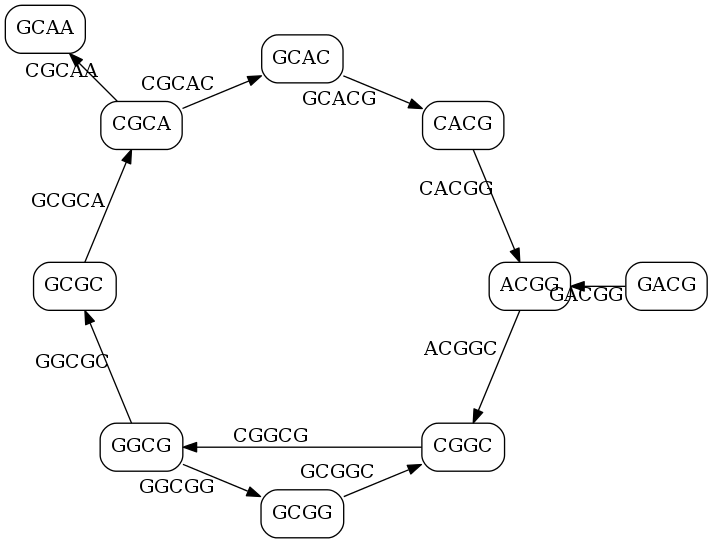

In [21]:
from IPython.display import Image
Image('TestGraph.png')